In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import glob
import os
import sys
from collections import deque
from copy import deepcopy

import numpy as np
import torch
import torch.nn as nn
import yaml
import yamlordereddictloader

from torchvision import models
from yaml import dump
# from dlrm.dlrm_s_pytorch import DLRM_Net, dash_separated_ints, dash_separated_floats
from ir.handlers import handlers
from ir.trace import trace
from ir.trace import get_backprop_memory
from utils.logger import create_logger
from utils.visualizer import plot_descent
from utils.visualizer import *

## DLRM

In [3]:
import sys
import argparse
import dlrm.dlrm_data_pytorch as dp
# ### parse arguments ###
parser = argparse.ArgumentParser(
    description="Train Deep Learning Recommendation Model (DLRM)"
)
# model related parameters
parser.add_argument("--arch-sparse-feature-size", type=int, default=2)
parser.add_argument(
    "--arch-embedding-size", type=dash_separated_ints, default="4-3-2"
)
# j will be replaced with the table number
parser.add_argument("--arch-mlp-bot", type=dash_separated_ints, default="4-3-2")
parser.add_argument("--arch-mlp-top", type=dash_separated_ints, default="4-2-1")
parser.add_argument(
    "--arch-interaction-op", type=str, choices=["dot", "cat"], default="dot"
)
parser.add_argument("--arch-interaction-itself", action="store_true", default=False)
# embedding table options
parser.add_argument("--md-flag", action="store_true", default=False)
parser.add_argument("--md-threshold", type=int, default=200)
parser.add_argument("--md-temperature", type=float, default=0.3)
parser.add_argument("--md-round-dims", action="store_true", default=False)
parser.add_argument("--qr-flag", action="store_true", default=False)
parser.add_argument("--qr-threshold", type=int, default=200)
parser.add_argument("--qr-operation", type=str, default="mult")
parser.add_argument("--qr-collisions", type=int, default=4)
# activations and loss
parser.add_argument("--activation-function", type=str, default="relu")
parser.add_argument("--loss-function", type=str, default="mse")  # or bce or wbce
parser.add_argument(
    "--loss-weights", type=dash_separated_floats, default="1.0-1.0"
)  # for wbce
parser.add_argument("--loss-threshold", type=float, default=0.0)  # 1.0e-7
parser.add_argument("--round-targets", type=bool, default=False)
# data
parser.add_argument("--data-size", type=int, default=1)
parser.add_argument("--num-batches", type=int, default=0)
parser.add_argument(
    "--data-generation", type=str, default="random"
)  # synthetic or dataset
parser.add_argument("--data-trace-file", type=str, default="./input/dist_emb_j.log")
parser.add_argument("--data-set", type=str, default="kaggle")  # or terabyte
parser.add_argument("--raw-data-file", type=str, default="")
parser.add_argument("--processed-data-file", type=str, default="")
parser.add_argument("--data-randomize", type=str, default="total")  # or day or none
parser.add_argument("--data-trace-enable-padding", type=bool, default=False)
parser.add_argument("--max-ind-range", type=int, default=-1)
parser.add_argument("--data-sub-sample-rate", type=float, default=0.0)  # in [0, 1]
parser.add_argument("--num-indices-per-lookup", type=int, default=10)
parser.add_argument("--num-indices-per-lookup-fixed", type=bool, default=False)
parser.add_argument("--num-workers", type=int, default=0)
parser.add_argument("--memory-map", action="store_true", default=False)
# training
parser.add_argument("--mini-batch-size", type=int, default=1)
parser.add_argument("--nepochs", type=int, default=1)
parser.add_argument("--learning-rate", type=float, default=0.01)
parser.add_argument("--print-precision", type=int, default=5)
parser.add_argument("--numpy-rand-seed", type=int, default=123)
parser.add_argument("--sync-dense-params", type=bool, default=True)
# inference
parser.add_argument("--inference-only", action="store_true", default=False)
# onnx
parser.add_argument("--save-onnx", action="store_true", default=False)
# gpu
parser.add_argument("--use-gpu", action="store_true", default=False)
# debugging and profiling
parser.add_argument("--print-freq", type=int, default=1)
parser.add_argument("--test-freq", type=int, default=-1)
parser.add_argument("--test-mini-batch-size", type=int, default=-1)
parser.add_argument("--test-num-workers", type=int, default=-1)
parser.add_argument("--print-time", action="store_true", default=False)
parser.add_argument("--debug-mode", action="store_true", default=False)
parser.add_argument("--enable-profiling", action="store_true", default=False)
parser.add_argument("--plot-compute-graph", action="store_true", default=False)
# store/load model
parser.add_argument("--save-model", type=str, default="")
parser.add_argument("--load-model", type=str, default="")
# mlperf logging (disables other output and stops early)
parser.add_argument("--mlperf-logging", action="store_true", default=False)
# stop at target accuracy Kaggle 0.789, Terabyte (sub-sampled=0.875) 0.8107
parser.add_argument("--mlperf-acc-threshold", type=float, default=0.0)
# stop at target AUC Terabyte (no subsampling) 0.8025
parser.add_argument("--mlperf-auc-threshold", type=float, default=0.0)
parser.add_argument("--mlperf-bin-loader", action="store_true", default=False)
parser.add_argument("--mlperf-bin-shuffle", action="store_true", default=False)
# LR policy
parser.add_argument("--lr-num-warmup-steps", type=int, default=0)
parser.add_argument("--lr-decay-start-step", type=int, default=0)
parser.add_argument("--lr-num-decay-steps", type=int, default=0)
args = parser.parse_args([])

# if args.mlperf_logging:
#     print("command line args: ", json.dumps(vars(args)))

### some basic setup ###
np.random.seed(args.numpy_rand_seed)
np.set_printoptions(precision=args.print_precision)
torch.set_printoptions(precision=args.print_precision)
torch.manual_seed(args.numpy_rand_seed)

if args.test_mini_batch_size < 0:
    # if the parameter is not set, use the training batch size
    args.test_mini_batch_size = args.mini_batch_size
if args.test_num_workers < 0:
    # if the parameter is not set, use the same parameter for training
    args.test_num_workers = args.num_workers

use_gpu = args.use_gpu and torch.cuda.is_available()
if use_gpu:
    torch.cuda.manual_seed_all(args.numpy_rand_seed)
    torch.backends.cudnn.deterministic = True
    device = torch.device("cuda", 0)
    ngpus = torch.cuda.device_count()  # 1
    print("Using {} GPU(s)...".format(ngpus))
else:
    device = torch.device("cpu")
    print("Using CPU...")

# ### prepare training data ###
ln_bot = np.fromstring(args.arch_mlp_bot, dtype=int, sep="-")
# input data
if args.data_generation == "dataset":

    train_data, train_ld, test_data, test_ld = dp.make_criteo_data_and_loaders(args)
    nbatches = args.num_batches if args.num_batches > 0 else len(train_ld)
    nbatches_test = len(test_ld)

    ln_emb = train_data.counts
    # enforce maximum limit on number of vectors per embedding
    if args.max_ind_range > 0:
        ln_emb = np.array(
            list(
                map(
                    lambda x: x if x < args.max_ind_range else args.max_ind_range,
                    ln_emb,
                )
            )
        )
    m_den = train_data.m_den
    ln_bot[0] = m_den
else:
    # input and target at random
    ln_emb = np.fromstring(args.arch_embedding_size, dtype=int, sep="-")
    m_den = ln_bot[0]
    train_data, train_ld = dp.make_random_data_and_loader(args, ln_emb, m_den)
    nbatches = args.num_batches if args.num_batches > 0 else len(train_ld)

### parse command line arguments ###
m_spa = args.arch_sparse_feature_size
num_fea = ln_emb.size + 1  # num sparse + num dense features
m_den_out = ln_bot[ln_bot.size - 1]
if args.arch_interaction_op == "dot":
    # approach 1: all
    # num_int = num_fea * num_fea + m_den_out
    # approach 2: unique
    if args.arch_interaction_itself:
        num_int = (num_fea * (num_fea + 1)) // 2 + m_den_out
    else:
        num_int = (num_fea * (num_fea - 1)) // 2 + m_den_out
elif args.arch_interaction_op == "cat":
    num_int = num_fea * m_den_out
else:
    sys.exit(
        "ERROR: --arch-interaction-op="
        + args.arch_interaction_op
        + " is not supported"
    )
arch_mlp_top_adjusted = str(num_int) + "-" + args.arch_mlp_top
ln_top = np.fromstring(arch_mlp_top_adjusted, dtype=int, sep="-")

# sanity check: feature sizes and mlp dimensions must match
if m_den != ln_bot[0]:
    sys.exit(
        "ERROR: arch-dense-feature-size "
        + str(m_den)
        + " does not match first dim of bottom mlp "
        + str(ln_bot[0])
    )
if args.qr_flag:
    if args.qr_operation == "concat" and 2 * m_spa != m_den_out:
        sys.exit(
            "ERROR: 2 arch-sparse-feature-size "
            + str(2 * m_spa)
            + " does not match last dim of bottom mlp "
            + str(m_den_out)
            + " (note that the last dim of bottom mlp must be 2x the embedding dim)"
        )
    if args.qr_operation != "concat" and m_spa != m_den_out:
        sys.exit(
            "ERROR: arch-sparse-feature-size "
            + str(m_spa)
            + " does not match last dim of bottom mlp "
            + str(m_den_out)
        )
else:
    if m_spa != m_den_out:
        sys.exit(
            "ERROR: arch-sparse-feature-size "
            + str(m_spa)
            + " does not match last dim of bottom mlp "
            + str(m_den_out)
        )
if num_int != ln_top[0]:
    sys.exit(
        "ERROR: # of feature interactions "
        + str(num_int)
        + " does not match first dimension of top mlp "
        + str(ln_top[0])
    )

ndevices = min(ngpus, args.mini_batch_size, num_fea - 1) if use_gpu else -1

# ### construct the neural network specified above ###
# # WARNING: to obtain exactly the same initialization for
# # the weights we need to start from the same random seed.
# # np.random.seed(args.numpy_rand_seed)
dlrm = DLRM_Net(
    m_spa,
    ln_emb,
    ln_bot,
    ln_top,
    arch_interaction_op=args.arch_interaction_op,
    arch_interaction_itself=args.arch_interaction_itself,
    sigmoid_bot=-1,
    sigmoid_top=ln_top.size - 2,
    sync_dense_params=args.sync_dense_params,
    loss_threshold=args.loss_threshold,
    ndevices=ndevices,
    qr_flag=args.qr_flag,
    qr_operation=args.qr_operation,
    qr_collisions=args.qr_collisions,
    qr_threshold=args.qr_threshold,
    md_flag=args.md_flag,
    md_threshold=args.md_threshold,
)
for j, (X, lS_o, lS_i, T) in enumerate(train_ld):
    Z = dlrm(X, lS_o, lS_i)
graph = trace(dlrm, (X, lS_o, lS_i))
print(graph)

NameError: name 'dash_separated_ints' is not defined

## Resnet and VGG

In [4]:
# Just preload the graph for fast experiments 
# Create Graph

for name, model in models.__dict__.items():
#     print(name)
    if not name.islower() or name.startswith("__") or not callable(model):
        continue
    if "vgg11" in name and "vgg11_bn" not in name :
        inputs = torch.randn(1, 3, 299, 299)
        vgg11_graph = trace(model().eval(), inputs) 
        print(vgg11_graph)
        break
       
#      if "resnet50" in name:
#         model = model().eval()
#         inputs = torch.randn(1, 3, 100, 100)
#         graph = trace(model, inputs)

torchvision.models.vgg.VGG (
	%input.1: float[1, 3, 299, 299],
	%1: float[64, 3, 3, 3],
	%2: float[64],
	%3: float[128, 64, 3, 3],
	%4: float[128],
	%5: float[256, 128, 3, 3],
	%6: float[256],
	%7: float[256, 256, 3, 3],
	%8: float[256],
	%9: float[512, 256, 3, 3],
	%10: float[512],
	%11: float[512, 512, 3, 3],
	%12: float[512],
	%13: float[512, 512, 3, 3],
	%14: float[512],
	%15: float[512, 512, 3, 3],
	%16: float[512],
	%17: float[4096, 25088],
	%18: float[4096],
	%19: float[4096, 4096],
	%20: float[4096],
	%21: float[1000, 4096],
	%22: float[1000]
):
	aten::_convolution
	aten::_convolution
	aten::_convolution
	aten::_convolution
	aten::_convolution
	aten::_convolution
	aten::_convolution
	aten::_convolution
	aten::adaptive_avg_pool2d
	aten::addmm
	aten::addmm
	aten::addmm
	return %329: float[1, 1000]


## Bert and GPT-2

In [10]:
from transformers import BertModel, BertConfig
from transformers import GPT2Model, GPT2Config
# configuration = BertConfig()
# model = BertModel(configuration)

configuration = GPT2Config()
model = GPT2Model(configuration)
# model.configMM

# tokenizer = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'tokenizer', 'bert-base-cased', do_basic_tokenize=False)

# Tokenized input
# text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
# tokenized_text = tokenizer.tokenize(text)
# indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# print(indexed_tokens)
### Get the hidden states computed by `bertModel`
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
indexed_tokens = [101, 2627, 1108, 3104, 1124, 15703, 136, 102, 3104, 1124, 15703, 1108, 170, 16797, 8284, 102]

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

# model = torch.hub.load('huggingface/pytorch-pretrained-BERT', 'model', 'bert-base-cased')
model.eval()

model(tokens_tensor)
graph = trace(model, tokens_tensor)
print(graph)

transformers.modeling_gpt2.GPT2Model (
	%0: long[1, 16],
	%1: float[50257, 768],
	%2: float[1024, 768],
	%3: float[768],
	%4: float[768],
	%5: byte[1, 1, 1024, 1024],
	%6: float[],
	%7: float[768, 2304],
	%8: float[2304],
	%9: float[768, 768],
	%10: float[768],
	%11: float[768],
	%12: float[768],
	%13: float[768, 3072],
	%14: float[3072],
	%15: float[3072, 768],
	%16: float[768],
	%17: float[768],
	%18: float[768],
	%19: byte[1, 1, 1024, 1024],
	%20: float[],
	%21: float[768, 2304],
	%22: float[2304],
	%23: float[768, 768],
	%24: float[768],
	%25: float[768],
	%26: float[768],
	%27: float[768, 3072],
	%28: float[3072],
	%29: float[3072, 768],
	%30: float[768],
	%31: float[768],
	%32: float[768],
	%33: byte[1, 1, 1024, 1024],
	%34: float[],
	%35: float[768, 2304],
	%36: float[2304],
	%37: float[768, 768],
	%38: float[768],
	%39: float[768],
	%40: float[768],
	%41: float[768, 3072],
	%42: float[3072],
	%43: float[3072, 768],
	%44: float[768],
	%45: float[768],
	%46: float[768],
	%47: byt

## Graph Neural Networks

In [13]:
from dgl.nn.pytorch import GraphConv
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)
# model = net(G,inputs)

G = build_karate_club_graph()
embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight
inputs = embed.weight



In [25]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
data = dataset[0] 
_, h = model(data.x, data.edge_index)
graph = trace(model, (data.x, data.edge_index))


## DARTS

In [6]:
import torch.nn as nn
import argparse

In [7]:
from collections import namedtuple

Genotype = namedtuple('Genotype', 'normal normal_concat reduce reduce_concat')

PRIMITIVES = [
    'none',
    'max_pool_3x3',
    'avg_pool_3x3',
    'skip_connect',
    'sep_conv_3x3',
    'sep_conv_5x5',
    'dil_conv_3x3',
    'dil_conv_5x5'
]

NASNet = Genotype(
  normal = [
    ('sep_conv_5x5', 1),
    ('sep_conv_3x3', 0),
    ('sep_conv_5x5', 0),
    ('sep_conv_3x3', 0),
    ('avg_pool_3x3', 1),
    ('skip_connect', 0),
    ('avg_pool_3x3', 0),
    ('avg_pool_3x3', 0),
    ('sep_conv_3x3', 1),
    ('skip_connect', 1),
  ],
  normal_concat = [2, 3, 4, 5, 6],
  reduce = [
    ('sep_conv_5x5', 1),
    ('sep_conv_7x7', 0),
    ('max_pool_3x3', 1),
    ('sep_conv_7x7', 0),
    ('avg_pool_3x3', 1),
    ('sep_conv_5x5', 0),
    ('skip_connect', 3),
    ('avg_pool_3x3', 2),
    ('sep_conv_3x3', 2),
    ('max_pool_3x3', 1),
  ],
  reduce_concat = [4, 5, 6],
)
    
AmoebaNet = Genotype(
  normal = [
    ('avg_pool_3x3', 0),
    ('max_pool_3x3', 1),
    ('sep_conv_3x3', 0),
    ('sep_conv_5x5', 2),
    ('sep_conv_3x3', 0),
    ('avg_pool_3x3', 3),
    ('sep_conv_3x3', 1),
    ('skip_connect', 1),
    ('skip_connect', 0),
    ('avg_pool_3x3', 1),
    ],
  normal_concat = [4, 5, 6],
  reduce = [
    ('avg_pool_3x3', 0),
    ('sep_conv_3x3', 1),
    ('max_pool_3x3', 0),
    ('sep_conv_7x7', 2),
    ('sep_conv_7x7', 0),
    ('avg_pool_3x3', 1),
    ('max_pool_3x3', 0),
    ('max_pool_3x3', 1),
    ('conv_7x1_1x7', 0),
    ('sep_conv_3x3', 5),
  ],
  reduce_concat = [3, 4, 6]
)

DARTS_V1 = Genotype(normal=[('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('skip_connect', 0), ('sep_conv_3x3', 1), ('skip_connect', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('skip_connect', 2)], normal_concat=[2, 3, 4, 5], reduce=[('max_pool_3x3', 0), ('max_pool_3x3', 1), ('skip_connect', 2), ('max_pool_3x3', 0), ('max_pool_3x3', 0), ('skip_connect', 2), ('skip_connect', 2), ('avg_pool_3x3', 0)], reduce_concat=[2, 3, 4, 5])
DARTS_V2 = Genotype(normal=[('sep_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 1), ('skip_connect', 0), ('skip_connect', 0), ('dil_conv_3x3', 2)], normal_concat=[2, 3, 4, 5], reduce=[('max_pool_3x3', 0), ('max_pool_3x3', 1), ('skip_connect', 2), ('max_pool_3x3', 1), ('max_pool_3x3', 0), ('skip_connect', 2), ('skip_connect', 2), ('max_pool_3x3', 1)], reduce_concat=[2, 3, 4, 5])

DARTS = DARTS_V2



In [8]:
class NetworkImageNet(nn.Module):

  def __init__(self, C, num_classes, layers, auxiliary, genotype):
    super(NetworkImageNet, self).__init__()
    self._layers = layers
    self._auxiliary = auxiliary

    self.stem0 = nn.Sequential(
      nn.Conv2d(3, C // 2, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(C // 2),
      nn.ReLU(inplace=True),
      nn.Conv2d(C // 2, C, 3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(C),
    )

    self.stem1 = nn.Sequential(
      nn.ReLU(inplace=True),
      nn.Conv2d(C, C, 3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(C),
    )

    C_prev_prev, C_prev, C_curr = C, C, C

    self.cells = nn.ModuleList()
    reduction_prev = True
    for i in range(layers):
      if i in [layers // 3, 2 * layers // 3]:
        C_curr *= 2
        reduction = True
      else:
        reduction = False
      cell = Cell(genotype, C_prev_prev, C_prev, C_curr, reduction, reduction_prev)
      reduction_prev = reduction
      self.cells += [cell]
      C_prev_prev, C_prev = C_prev, cell.multiplier * C_curr
      if i == 2 * layers // 3:
        C_to_auxiliary = C_prev

    if auxiliary:
      self.auxiliary_head = AuxiliaryHeadImageNet(C_to_auxiliary, num_classes)
    self.global_pooling = nn.AvgPool2d(7)
    self.classifier = nn.Linear(C_prev, num_classes)

  def forward(self, input):
    logits_aux = None
    s0 = self.stem0(input)
    s1 = self.stem1(s0)
    for i, cell in enumerate(self.cells):
      s0, s1 = s1, cell(s0, s1, self.drop_path_prob)
      if i == 2 * self._layers // 3:
        if self._auxiliary and self.training:
          logits_aux = self.auxiliary_head(s1)
    out = self.global_pooling(s1)
    logits = self.classifier(out.view(out.size(0), -1))
    return logits, logits_aux



In [9]:
class AuxiliaryHeadImageNet(nn.Module):

  def __init__(self, C, num_classes):
    """assuming input size 14x14"""
    super(AuxiliaryHeadImageNet, self).__init__()
    self.features = nn.Sequential(
      nn.ReLU(inplace=True),
      nn.AvgPool2d(5, stride=2, padding=0, count_include_pad=False),
      nn.Conv2d(C, 128, 1, bias=False),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 768, 2, bias=False),
      # NOTE: This batchnorm was omitted in my earlier implementation due to a typo.
      # Commenting it out for consistency with the experiments in the paper.
      # nn.BatchNorm2d(768),
      nn.ReLU(inplace=True)
    )
    self.classifier = nn.Linear(768, num_classes)

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x.view(x.size(0),-1))
    return x


In [10]:
class Cell(nn.Module):

  def __init__(self, genotype, C_prev_prev, C_prev, C, reduction, reduction_prev):
    super(Cell, self).__init__()
    print(C_prev_prev, C_prev, C)

    if reduction_prev:
      self.preprocess0 = FactorizedReduce(C_prev_prev, C)
    else:
      self.preprocess0 = ReLUConvBN(C_prev_prev, C, 1, 1, 0)
    self.preprocess1 = ReLUConvBN(C_prev, C, 1, 1, 0)
    
    if reduction:
      op_names, indices = zip(*genotype.reduce)
      concat = genotype.reduce_concat
    else:
      op_names, indices = zip(*genotype.normal)
      concat = genotype.normal_concat
    self._compile(C, op_names, indices, concat, reduction)

  def _compile(self, C, op_names, indices, concat, reduction):
    assert len(op_names) == len(indices)
    self._steps = len(op_names) // 2
    self._concat = concat
    self.multiplier = len(concat)

    self._ops = nn.ModuleList()
    for name, index in zip(op_names, indices):
      stride = 2 if reduction and index < 2 else 1
      op = OPS[name](C, stride, True)
      self._ops += [op]
    self._indices = indices

  def forward(self, s0, s1, drop_prob):
    s0 = self.preprocess0(s0)
    s1 = self.preprocess1(s1)

    states = [s0, s1]
    for i in range(self._steps):
      h1 = states[self._indices[2*i]]
      h2 = states[self._indices[2*i+1]]
      op1 = self._ops[2*i]
      op2 = self._ops[2*i+1]
      h1 = op1(h1)
      h2 = op2(h2)
      if self.training and drop_prob > 0.:
        if not isinstance(op1, Identity):
          h1 = drop_path(h1, drop_prob)
        if not isinstance(op2, Identity):
          h2 = drop_path(h2, drop_prob)
      s = h1 + h2
      states += [s]
    return torch.cat([states[i] for i in self._concat], dim=1)

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, default='../data/imagenet/', help='location of the data corpus')
parser.add_argument('--batch_size', type=int, default=128, help='batch size')
parser.add_argument('--learning_rate', type=float, default=0.1, help='init learning rate')
parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--weight_decay', type=float, default=3e-5, help='weight decay')
parser.add_argument('--report_freq', type=float, default=100, help='report frequency')
parser.add_argument('--gpu', type=int, default=0, help='gpu device id')
parser.add_argument('--epochs', type=int, default=250, help='num of training epochs')
parser.add_argument('--init_channels', type=int, default=48, help='num of init channels')
parser.add_argument('--layers', type=int, default=14, help='total number of layers')
parser.add_argument('--auxiliary', action='store_true', default=False, help='use auxiliary tower')
parser.add_argument('--auxiliary_weight', type=float, default=0.4, help='weight for auxiliary loss')
parser.add_argument('--drop_path_prob', type=float, default=0, help='drop path probability')
parser.add_argument('--save', type=str, default='EXP', help='experiment name')
parser.add_argument('--seed', type=int, default=0, help='random seed')
parser.add_argument('--arch', type=str, default='DARTS', help='which architecture to use')
parser.add_argument('--grad_clip', type=float, default=5., help='gradient clipping')
parser.add_argument('--label_smooth', type=float, default=0.1, help='label smoothing')
parser.add_argument('--gamma', type=float, default=0.97, help='learning rate decay')
parser.add_argument('--decay_period', type=int, default=1, help='epochs between two learning rate decays')
parser.add_argument('--parallel', action='store_true', default=False, help='data parallelism')
args = parser.parse_args([])

In [12]:
import torch
import torch.nn as nn
from plugins.darts.cnn.operations import *

In [30]:
CLASSES = 1000

model = NetworkImageNet(args.init_channels, CLASSES, args.layers, args.auxiliary, DARTS)

# graph = trace(model, input)

48 48 48
48 192 48
192 192 48
192 192 48
192 192 96
192 384 96
384 384 96
384 384 96
384 384 96
384 384 192
384 768 192
768 768 192
768 768 192
768 768 192


## GAN 

In [7]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', required=True, help='cifar10 | lsun | mnist |imagenet | folder | lfw | fake')
# parser.add_argument('--dataroot', required=True, help='path to dataset')
parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
parser.add_argument('--batchSize', type=int, default=64, help='input batch size')
parser.add_argument('--imageSize', type=int, default=64, help='the height / width of the input image to network')
parser.add_argument('--nz', type=int, default=100, help='size of the latent z vector')
parser.add_argument('--ngf', type=int, default=64)
parser.add_argument('--ndf', type=int, default=64)
parser.add_argument('--niter', type=int, default=25, help='number of epochs to train for')
parser.add_argument('--lr', type=float, default=0.0002, help='learning rate, default=0.0002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='enables cuda')
parser.add_argument('--ngpu', type=int, default=1, help='number of GPUs to use')
parser.add_argument('--netG', default='', help="path to netG (to continue training)")
parser.add_argument('--netD', default='', help="path to netD (to continue training)")
parser.add_argument('--outf', default='.', help='folder to output images and model checkpoints')
parser.add_argument('--manualSeed', type=int, help='manual seed')
parser.add_argument('--classes', default='bedroom', help='comma separated list of classes for the lsun data set')

opt = parser.parse_args([])
print(opt)

try:
    os.makedirs(opt.outf)
except OSError:
    pass

if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)

cudnn.benchmark = True

device = torch.device("cuda:0" if opt.cuda else "cpu")
ngpu = int(opt.ngpu)
nz = int(opt.nz)
ngf = int(opt.ngf)
ndf = int(opt.ndf)
nc = 3

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = Generator(ngpu).to(device)
netG.apply(weights_init)
if opt.netG != '':
    netG.load_state_dict(torch.load(opt.netG))
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
if opt.netD != '':
    netD.load_state_dict(torch.load(opt.netD))
print(netD)

criterion = nn.BCELoss()

fixed_noise = torch.randn(opt.batchSize, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

# ############################
# # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
# ###########################
# # train with real
# netD.zero_grad()
# real_cpu = data[0].to(device)
# batch_size = real_cpu.size(0)
# label = torch.full((batch_size,), real_label, device=device)

# output = netD(real_cpu)
# errD_real = criterion(output, label)
# errD_real.backward()
# D_x = output.mean().item()

# # train with fake
# noise = torch.randn(batch_size, nz, 1, 1, device=device)
# fake = netG(noise)
# label.fill_(fake_label)
# output = netD(fake.detach())
# errD_fake = criterion(output, label)
# errD_fake.backward()
# D_G_z1 = output.mean().item()
# errD = errD_real + errD_fake
# optimizerD.step()

# ############################
# # (2) Update G network: maximize log(D(G(z)))
# ###########################
# netG.zero_grad()
# label.fill_(real_label)  # fake labels are real for generator cost
# output = netD(fake)
# errG = criterion(output, label)
# errG.backward()
# D_G_z2 = output.mean().item()
# optimizerG.step()

Namespace(batchSize=64, beta1=0.5, classes='bedroom', cuda=False, imageSize=64, lr=0.0002, manualSeed=None, ndf=64, netD='', netG='', ngf=64, ngpu=1, niter=25, nz=100, outf='.', workers=2)
Random Seed:  1804
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=

## Scheduling Class 

In [5]:
from generator import Generator, get_mem_props, get_compute_props
from utils.visualizer import *


In [6]:
import collections
import pdb

import numpy as np
import yaml
import yamlordereddictloader

from utils.logger import create_logger


class Scheduling:
    def __init__(self, hwfile="default.yaml"):
        base_dir = "configs/"
        self.total_cycles = 0
        self.logger = create_logger("logs/stats.txt")
        self.config = self.create_config(
            yaml.load(open(base_dir + hwfile), Loader=yamlordereddictloader.Loader)
        )


In [7]:
def create_config(self, config):

    self.logger.info("Config Statistics : ")

    self.mle = config["memory_levels"]
    self.mem_energy = np.zeros((self.mle))
    self.compute_energy = 0
    self.mem_read_access = np.zeros((self.mle))
    self.mem_write_access = np.zeros((self.mle))
    self.mem_size = np.zeros((self.mle))
    self.mem_util = np.zeros((self.mle))
    self.mem_free = np.zeros((self.mle))
    self.mem_read_bw = np.zeros((self.mle))
    self.mem_write_bw = np.zeros((self.mle))
    self.internal_bandwidth_time = 0
    self.total_cycles = 0 
    self.bandwidth_idle_time = 0
    self.compute_idle_time = 0
    self.mem_size_idle_time = 0
    self.force_connectivity = False
    mm_compute = config["mm_compute"]
    vector_compute = config["vector_compute"]

    if config["mm_compute"]["class"] == "systolic_array":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"]) ** 2) * mm_compute["N_PE"] / 2
        )
        config["comp_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

        self.logger.info(
            "MM Compute per cycle : %d", config["mm_compute_per_cycle"]
        )
        self.logger.info("Compute Bandwidth Required : %d", config["comp_bw"])

    if config["mm_compute"]["class"] == "mac":
        config["mm_compute_per_cycle"] = (
            ((mm_compute["size"])) * mm_compute["N_PE"] / 2
        )
        config["comp_read_bw"] = (
            mm_compute["size"] * mm_compute["N_PE"] * mm_compute["frequency"] * 2
        )

    for i in range(self.mle):
        memory = config["memory"]["level" + str(i)]
        self.mem_read_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["read_ports"]
            * memory["width"]
        )
        self.mem_write_bw[i] = (
            memory["frequency"]
            * memory["banks"]
            * memory["write_ports"]
            * memory["width"]
        )
        self.mem_size[i] = memory["size"]
        
        self.logger.info(
            "Memory at Level %d, Read Bandwidth %d Write Bandwidth %d",
            i,
            self.mem_read_bw[i],
            self.mem_write_bw[i],
        )
    for i in range(self.mle - 1):
        memory = config["memory"]["level" + str(i)]
        read_energy, write_energy, leakage_power = get_mem_props(
            memory["size"], memory["width"], memory["banks"]
        )
        config["memory"]["level" + str(i)]["read_energy"] = str(read_energy)
        config["memory"]["level" + str(i)]["write_energy"] = str(write_energy)
        config["memory"]["level" + str(i)]["leakage_power"] = str(leakage_power)
    return config

## Runner Function

In [8]:
def run(self, graph):

    """
     Check both size, utilization and bandwidths at every node
     What about memory size that can also get exhausted ?
     So if memory size is exhausted, then have to go to a previous level and write there ?
     if any level utilization is exhausted then only the immediate memory required will be kept.
     if the memory is empty in size, but is not bandwidth, it is useless?
     Cannot do prefetching
     Read access of the next node will decrease
     Bandwidth is available but size is not?, can do prefetching, but now the memory fetches have to check, 
     whether to do fetches of the same node or a different node
     Say bandwidth at level0 is sufficient, at level1 is insufficient, then at level1 we have a bottlenecks
     slower so it will take its own time
     Do vector operations in the meantime perhaps ? 

    """

    config = self.config

    read_bw_req = []
    write_bw_req = []
    read_bw_actual = []
    write_bw_actual = []
    cycles = []
    free_cycles = []
    transferable_checkpointed_edge = []
    all_checkpointed_edge = []
    self.mem_util_log=[]
    self.mem_util_full=[]
    # Mem Fetch time of the last Nodes
#     print(self.mem_free[0], self.mem_util[0], self.mem_size[0])

    mem_free = True
    for n, node in enumerate(graph.nodes):

        # These are last level read/write accesses
        compute_expense, read_access, write_access = node.get_stats()
#         print(read_access, node.in_edge_mem)
        
        self.mem_read_access[1]+=(read_access)
      
        self.logger.info(node.get_stats())
        self.mem_util[0] += node.in_edge_mem
        
        # Total Free memory
        for i in range(self.mle - 1):
            self.mem_free[i] = self.mem_size[i] - self.mem_util[i]
            
#         print("2",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        time_compute = compute_expense / config["mm_compute_per_cycle"]
        read_bw_ll = read_access / (time_compute)
        write_bw_ll = write_access / (time_compute)
        step_cycles = time_compute
        read_bw_req.append(read_bw_ll)
        write_bw_req.append(write_bw_ll)
        free_cycles.append(step_cycles)
#         print("bandwidth",read_bw_ll, write_bw_ll, step_cycles) 
        
        if self.mem_free[0] < node.mem_util:
            mem_free = False
            # node mem_util = output edge
            self.logger.info("Memory size is too low/ Memory is Full")
            self.logger.info("Node or Node memory Requirements too high")
            # Rearrange the checkpointed_nodes
            # rearrange = True

            # Is it possible now : Otherwise update the last level memory bandwidth requirements
            if(self.mem_free[0]<0):      
                step_cycles += 2*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)*(
                   (self.mem_free[0]+node.in_edge_mem)  / self.mem_read_bw[self.mle - 1]
                ) + time_compute*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)/256
                # Change this later with the number of solid total cycles
                self.mem_size_idle_time += 2*(node.in_edge_mem//self.mem_read_bw[self.mle - 1]) + time_compute/256*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem) + 1)
                self.mem_read_access[0]+=node.in_edge_mem*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem)) 
                self.mem_write_access[0]+=node.in_edge_mem*(node.in_edge_mem//(self.mem_free[0]+node.in_edge_mem)) 
        else:
            self.mem_util[0] += node.mem_util
            self.mem_free[0] -= node.mem_util
#         print("2.5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        self.mem_util_log.append(self.mem_util[0])
        self.mem_read_access[0]+=node.mem_util
        self.mem_write_access[0]+=node.mem_util
            
        assert(self.mem_free[0] < self.mem_size[0])
        # Last level memory fetch takes more time, so that may be a bottleneck
        bandwidth_available = read_bw_ll < self.mem_read_bw[self.mle - 1]
        
        # If Bandwidth is not available : Cannot Prefetch
        if (bandwidth_available) == False:
            step_cycles += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute
            self.bandwidth_idle_time += (
                read_bw_ll / self.mem_read_bw[self.mle - 1]
            - 1) * time_compute

        # If memory is not free for the next node and Bandwidth is available : Move nodes back and forth
        # if(total_mem_free[0] == 0 and (bandwidth_available)):
        # for(nodes in checkpointed_nodes):
        # checkpointed but not immediate node

        # Check if memory is free and Bandwidth available : From the Data Dependence Graph, Prefetch new node

        # pdb.set_trace()
        if self.mem_free[0] > 0 and (bandwidth_available):
            if n < len(graph.nodes) - 1:
                if self.mem_free[0] > node.next.mem_util:
                    read_access += node.next.mem_util
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        self.mem_util[0] += node.next.mem_util
                        self.mem_write_access[0] += node.next.mem_util
                        self.mem_free[0] -= node.next.mem_util
                        node.next.mem_util = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_write_access[0]+=read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_util = read_access - read_bw_ll * step_cycles

                else:
                    read_access += self.mem_free[0]
                    if read_access / step_cycles < self.mem_read_bw[self.mle - 1]:
                        node.next.mem_util = node.next.mem_util - self.mem_free[0]
                        self.mem_util[0] = self.mem_size[0]
                        self.mem_free[0] = 0
                    else:
                        read_access = self.mem_read_bw[self.mle - 1] * step_cycles
                        self.mem_util[0] += read_access - read_bw_ll * step_cycles
                        self.mem_free[0] -= read_access - read_bw_ll * step_cycles
                        node.next.mem_util = read_access - read_bw_ll * step_cycles
#         print("3",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        self.mem_util_full.append(self.mem_util[0])   
        
            # TODO Consider Write bandwidth for a block read memory or Write Bandwidth  for a endurance purposes
        self.mem_util[0] -= node.in_edge_mem
#         print("4",self.mem_free[0], self.mem_util[0], self.mem_size[0])
    
        if mem_free:
            self.mem_util[0] -= node.mem_util
#         print("5",self.mem_free[0], self.mem_util[0], self.mem_size[0])
        
        self.logger.info(
            "Node operator %r, Step Cycles %d, Read Accesses %d, Write Accesses %d ",
            node.operator,
            step_cycles,
            read_access,
            write_access,
        )
        self.total_cycles += step_cycles
        cycles.append(step_cycles)
        read_bw_actual.append(read_access / step_cycles)
        write_bw_actual.append(write_access / step_cycles)
#         print("actual",read_access / step_cycles, write_access / step_cycles, step_cycles)
#     print("The total cycles are ", self.total_cycles)
    return read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles

In [9]:
Scheduling.create_config = create_config
Scheduling.run = run

## Runner Forward and Runner Functions 

In [10]:
def runner_forward(graph_set):
    """
    Runs the Input Graph
    """ 
    generator = Generator()
    bandwidth = [2,10,50,75,100]
    for graph in graph_set:
#     for i in range(len(bandwidth)):
        scheduler = Scheduling()
#         scheduler.mem_read_bw[1] = 10*bandwidth[i]
        read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
        read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
#         bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)
#         cycles_bar_graph("cycles.png", cycles, free_cycles, graph.nodes)
#         mem_util_bar_graph("mem_util.png",scheduler.mem_util_full/scheduler.mem_size[0],scheduler.mem_util_log/scheduler.mem_size[0], graph.nodes)
#         generator.save_statistics(scheduler, True, get_backprop_memory(graph.nodes))
        time, energy = generator.save_stats(scheduler)
     


In [11]:
# runner_forward([vgg11_graph])

In [13]:
def runner(graph_set, scheduler):
    """
    Runs the Input Graph
    """ 
    time_list = []
    energy_list=[]
    bandwidth_time_list = []
    mem_size_idle_time_list=[]
    bank_list=[]
    mem_size_list=[]
    compute_list=[]
    tech_params_list = []
    num_iterations = 6
    generator = Generator()
    bandwidth = [2,10,50,75,100]
    for graph in graph_set:
#     for i in range(len(bandwidth)):
#         scheduler.mem_read_bw[1] = 10*bandwidth[i]
        read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
        read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
#         bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)
#         cycles_bar_graph("cycles.png", cycles, free_cycles, graph.nodes)
#         mem_util_bar_graph("mem_util.png",scheduler.mem_util_full/scheduler.mem_size[0],scheduler.mem_util_log/scheduler.mem_size[0], graph.nodes)
#         generator.save_statistics(scheduler, True, get_backprop_memory(graph.nodes))
        time, energy, design, tech = generator.save_stats(scheduler)
        time_list.append(time[0])
        energy_list.append(energy[0])
        bandwidth_time_list.append(time[1])
        mem_size_idle_time_list.append(time[2])
        bank_list.append(design[0])
        mem_size_list.append(design[1])
        tech_params_list.append(tech)
        #         print(scheduler.config)
        for i in range(num_iterations):
            config = generator.backward_pass(scheduler, "time")
            generator.writeconfig(config, str(i) + "hw.yaml")
            scheduler.create_config(config)
            read_bw_req, write_bw_req, read_bw_actual, write_bw_actual, cycles, free_cycles = scheduler.run(graph)
#             read_bw_limit, write_bw_limit = scheduler.mem_read_bw[scheduler.mle - 1], scheduler.mem_write_bw[scheduler.mle - 1]   
# #             bandwidth_bar_graph("read_full.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes, cycles)
            time, energy, design, tech = generator.save_stats(scheduler)
            time_list.append(time[0])
            energy_list.append(energy[0])
            bandwidth_time_list.append(time[1])
            mem_size_idle_time_list.append(time[2])
            bank_list.append(design[0])
            mem_size_list.append(design[1])
        return [time_list, bandwidth_time_list, mem_size_idle_time_list, bank_list, mem_size_list, compute_list, tech_params_list]


## Plot Descent

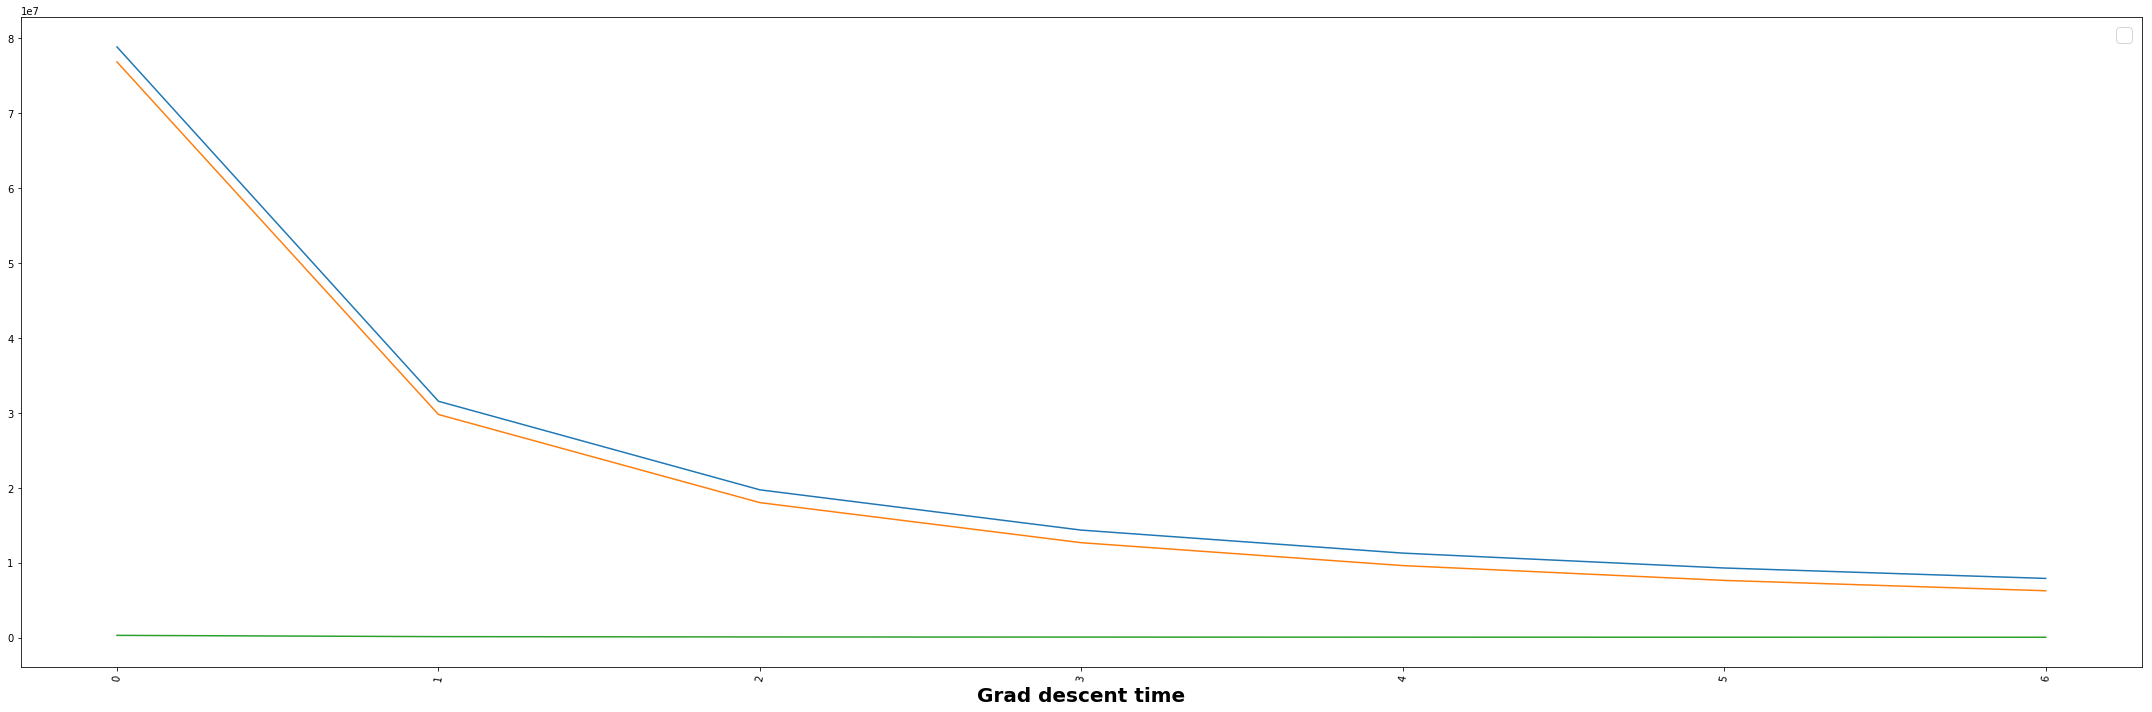

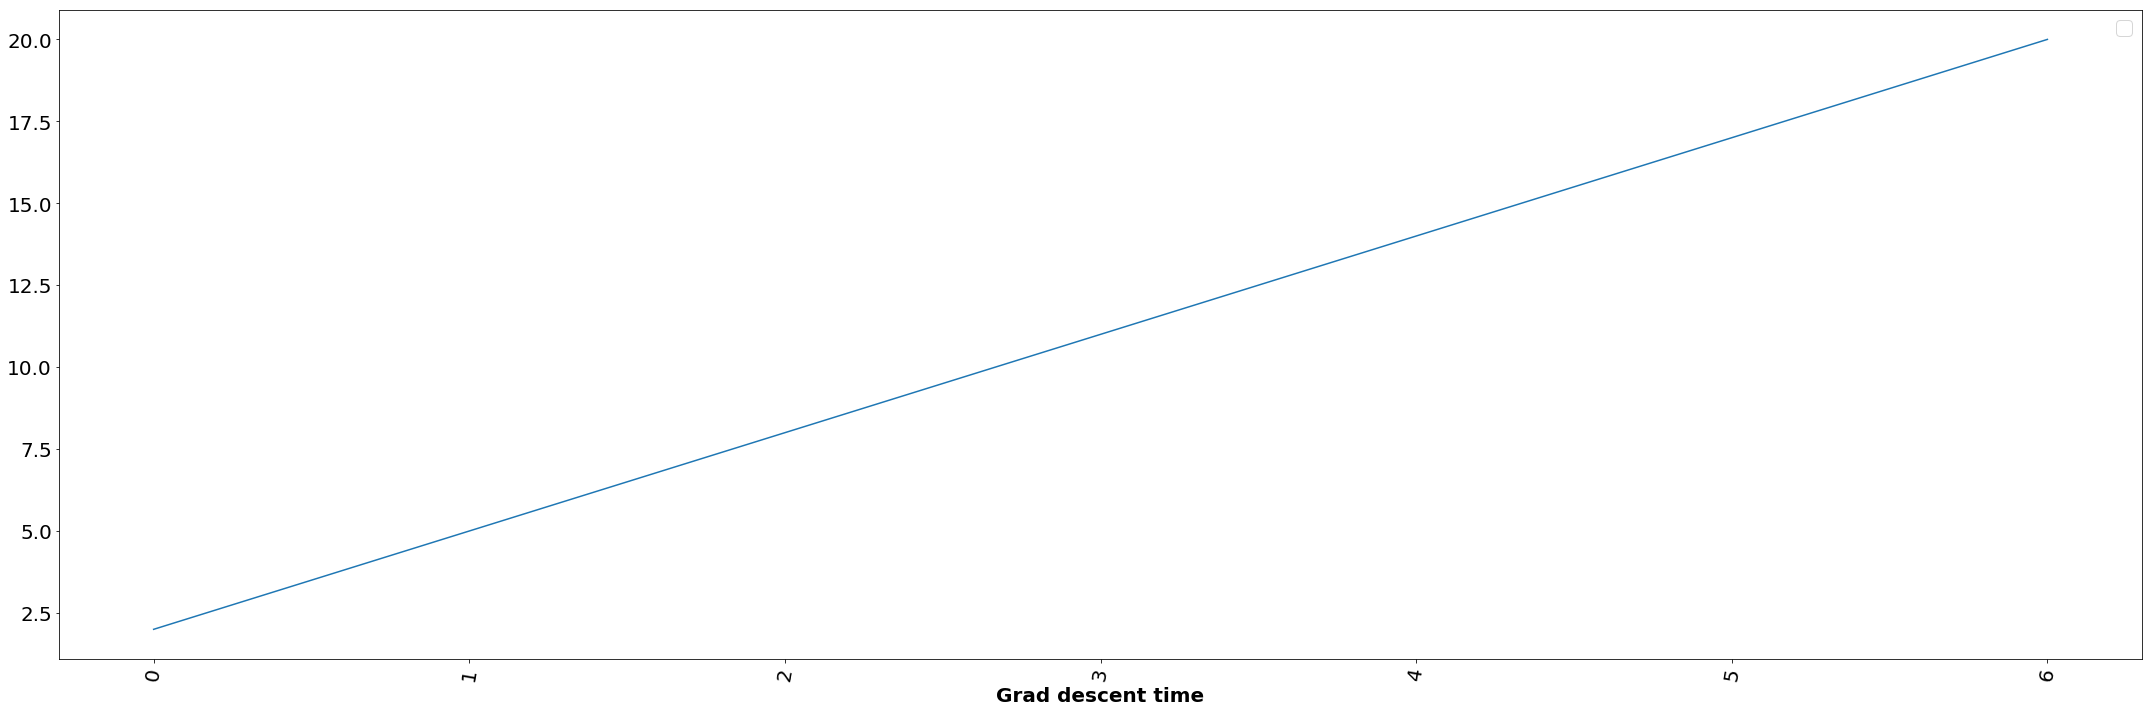

NameError: name 'time_list' is not defined

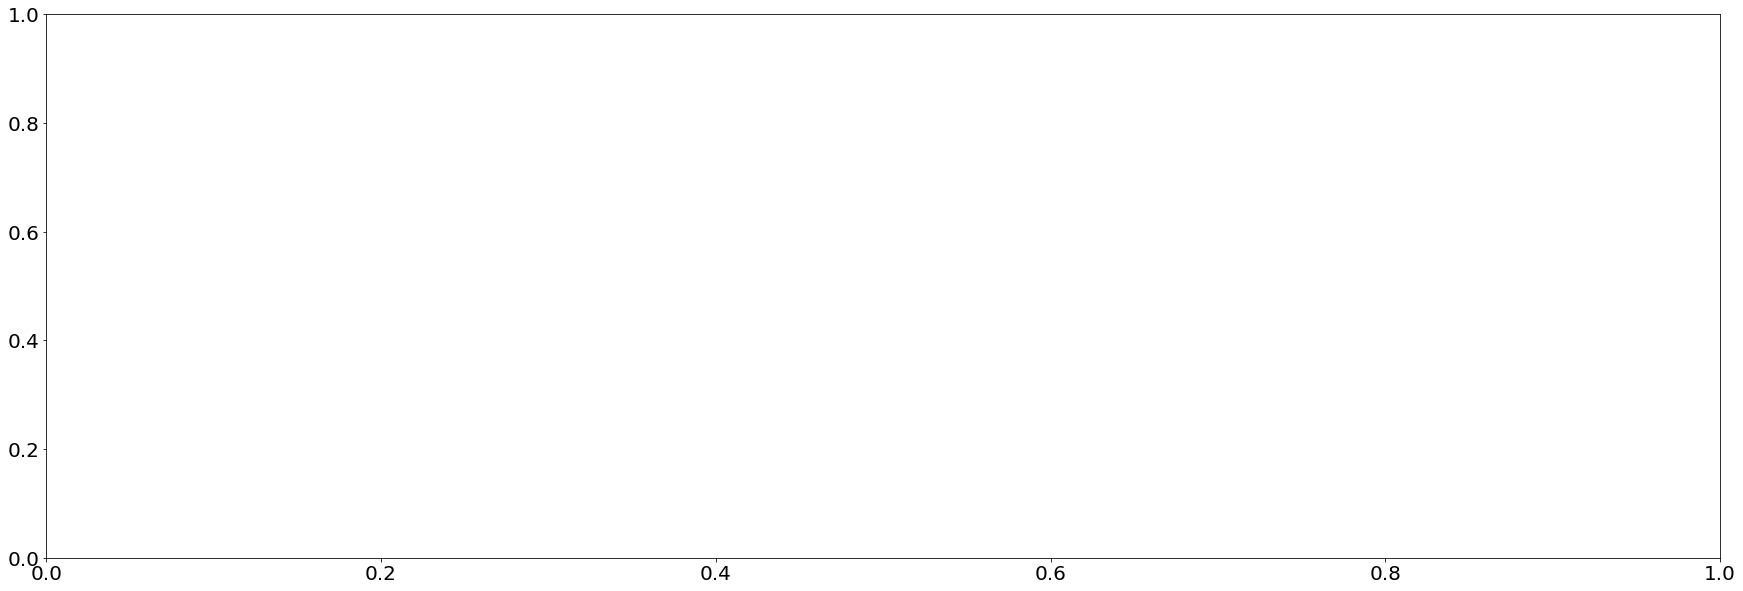

In [16]:
scheduler = Scheduling()
time_list, bandwidth_time_list, mem_size_idle_time_list, bank_list, mem_size_list, compute_list, tech_params = runner([vgg11_graph], scheduler)
plot_descent(time_list, bandwidth_time_list, mem_size_idle_time_list)
## Plot Design Parameters change over time
plot_design_param_change(bank_list, mem_size_list, compute_list)
## Plot Technology Parameters change over time
plot_tech_param_change(tech_params)

## Multiple Sweep Memory Banks/Connectivity

In [35]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax2 = ax.twinx()
# base_dir = "figures/"
# error_config = {"ecolor": "0.3"}
# index = np.arange(6)
# for j in range(5):
#     scheduler = Scheduling()
#     scheduler.config["memory"]["level1"]["frequency"]=5
#     scheduler.config["memory"]["level1"]["frequency"]*=2**j
#     time_list, bandwidth_time_list,_,_,_= runner([vgg11_graph],scheduler)
#     plot_descent_multiple(ax, time_list, bandwidth_time_list)
#     plot_parameter_change_multiple(ax2, bank_list)

# ax.legend(fontsize=20)
# ax.set_xticks(index)
# plt.xticks(rotation=80)
# plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=20)
# ax.set_ylabel("Grad descent time", fontsize=20, fontweight="bold")
# ax2.set_ylabel("Grad descent parameters", fontsize=20, fontweight="bold")
# fig.tight_layout()
# plt.yscale("log")
# plt.savefig(base_dir + "multiple_bandwidth.png", bbox_inches="tight")
# plt.show()

## Multiple Sweep Memory Size

In [36]:
# fig, ax = plt.subplots(figsize=(10, 10))
# ax2 = ax.twinx()
# base_dir = "figures/"
# error_config = {"ecolor": "0.3"}
# index = np.arange(6)
# for i in range(5,10):
#     scheduler = Scheduling()
#     scheduler.config["memory"]["level0"]["size"]=10**(i/2)
#     time_list, bandwidth_time_list,mem_size_idle_time_list, bank_list, mem_size_list, compute_list = runner([vgg11_graph],scheduler)
#     plot_descent_multiple(ax, time_list, mem_size_idle_time_list)
#     plot_parameter_change_multiple(ax2, mem_size_list)

# ax.legend(fontsize=20)
# ax.set_xticks(index)
# plt.xticks(rotation=80)
# plt.rc("xtick", labelsize=20)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=20)
# ax.set_ylabel("Grad descent time", fontsize=20, fontweight="bold")
# ax2.set_ylabel("Grad descent parameters", fontsize=20, fontweight="bold")
# fig.tight_layout()
# plt.yscale("log")
# plt.savefig(base_dir + "memory_size_multiple.png", bbox_inches="tight")
# plt.show()

# Technology Tables

In [116]:
import numpy as np
import pandas as pd
d = pd.read_csv('tables/sram.csv')
a = np.array(d)

input = a[:,:3]
# output = a[:,3:]


In [53]:
d = pd.read_csv('plugins/cacti/bus_width.out')


d = d.drop(d.columns[[0,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]], axis=1)

d = d.drop(' Associativity',1)
d = d.drop(' Dynamic search energy (nJ)',1)

In [55]:
a= np.array(d)
np.savetxt('bus.csv',a, fmt='%.18e', delimiter=',')



In [ ]:
bar_graph("read_dummy.png", read_bw_req, read_bw_actual, read_bw_limit, graph.nodes)


In [232]:
mem_table = np.array(pd.read_csv("tables/sram.csv", header=None))
a = mem_table[np.where(mem_table[:, 1] == 4)]
a = a[np.where(a[:, 2] == 32)]

compute:
    name       : MACs
        class      : mac
        attributes :            
        instances       : 256
        meshX           : 16
        word-bits       : 16

    memory: 
        name       : DRAM
        class      : DRAM
        attributes :
        instances       : 1
        word-bits       : 16
  
    name       : OutputBuffer
        class      : SRAM
        attributes :
        entries         : 1024  # 64 * 16 = 1024
        instances       : 1
        meshX           : 1
        word-bits       : 16
        block-size      : 16
        read_bandwidth  : 16 # words/cycle
        write_bandwidth : 16 # words/cycle

        name       : InputBuffer
            class      : SRAM
            attributes :
            entries         : 1024 # 64 * 16 = 1024
            instances       : 1
            meshX           : 1
            word-bits       : 16
            block-size      : 16
            read_bandwidth  : 16 # words/cycle
            write_bandwidth : 16 # words/cycle

        name       : PsumRegFile
            class      : regfile
            attributes :
            entries         : 1
            instances       : 16
            meshX           : 16
            word-bits       : 16
            cluster-size    : 16
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
            
        name       : WeightBuffer
            class      : regfile
            attributes :
            entries         : 64
            instances       : 256
            meshX           : 16
            word-bits       : 16
            cluster-size    : 256
            read_bandwidth  : 1  # words/cycle
            write_bandwidth : 1  # words/cycle
    noc:

